# Deep Q Learning
## Q Learning refresher
The simplest version of Q-Learning (Tabular Q-learning) holds a table of (state x actions) that is populated by the agent having experiences with the environment. The idea is to learn the Action Value Function $Q(s,a)$ through experiences and their rewards.

The only problem of this approach is that holding a table for enviroments that have lots of states will be intractable, to solve this issue we use a function approximator (Neural Network) that will generalize and learn a parametrized action value function $Q_{\theta}(s,a)$.

### Loss Function
We can use as loss function the Mean Squared error between the model prediction of the Q value and a target calculated with the Bellman Equation
![alt text](imgs/loss_func_aprox.png "Game")

### Q Learning Update equation
The update equation will provides us the target for our loss function.
$$Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \big[r_t + \gamma \max\limits_{a} Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)\big]$$
```python
Q_target[action] = reward + torch.mul(maxQ1.detach(), gamma)
```


#### References
* https://medium.com/@jonathan_hui/rl-dqn-deep-q-network-e207751f7ae4
* https://medium.freecodecamp.org/an-introduction-to-deep-q-learning-lets-play-doom-54d02d8017d8
* https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
* https://github.com/blackredscarf/pytorch-DQN
* https://medium.com/mlreview/speeding-up-dqn-on-pytorch-solving-pong-in-30-minutes-81a1bd2dff55
* https://www.toptal.com/deep-learning/pytorch-reinforcement-learning-tutorial
* https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf
* https://keon.io/deep-q-learning/

In [1]:
import matplotlib.pyplot as plt
import gym
import numpy as np
from tqdm import tqdm, trange
import pandas as pd
from tensorboardX import SummaryWriter
from datetime import datetime
import tensorflow as tf
import glob, os, time
from IPython.display import clear_output

# Hyper parameters
epsilon = 0.3
gamma = 0.99
learning_rate = 0.001
max_position = -0.4
loss_history = []
reward_history = []
episodes = 300
successes = 0
position = []

### Initialize Mountain Car v0 Environment
The problem we will be dealing with is the Mountain Car environment, where you need to bring the car to the position 0.5.

#### States
Num | Observation  | Min  | Max  
----|--------------|------|----   
0   | position     | -1.2 | 0.6
1   | velocity     | -0.07| 0.07

#### Actions
Num | Action|
----|-------------|
0   | push left   |
1   | no push     |
2   | push right  |

#### Reward
-1 for each time step, until the goal position of 0.5 is reached. As with MountainCarContinuous v0, there is no penalty for climbing the left hill, which upon reached acts as a wall.

#### Episode Termination
The episode ends when you reach 0.5 position, or if 200 iterations are reached.


In [2]:
env = gym.make('MountainCar-v0')
# Set fixed random seeds
env.seed(3); np.random.seed(3); tf.random.set_seed(1)
# Writer for tensorboard
writer = SummaryWriter('./tboardlogs/{}'.format(datetime.now().strftime('%b%d_%H-%M-%S')))

### Declare Model for Q Function Approximation

In [3]:
class Q_func_approx:
    def __init__(self):
        #super(Q_func_approx, self).__init__()
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        self.hidden = 100
        
        
        #self.layer1 = nn.Linear(self.state_space, self.hidden, bias=False)
        #self.layer2 = nn.Linear(self.hidden, self.action_space, bias=False)
        
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(self.hidden, activation='relu'),
            tf.keras.layers.Dense(self.action_space)
        ])
    
    #@tf.function
    def forward(self, x, is_training=True):   
        # Convert state to tensor
        #state = torch.from_numpy(x).type(torch.FloatTensor)
        #res = self.layer1(state)
        #res = self.layer2(res)
        x = x[np.newaxis, :]
        x = tf.cast(x, tf.float32)
        res = self.model(x, training=is_training)
        return res[0]
    
    
    #@tf.function
    def train(self, loss_fn, optimizer, Q, Q_target):
        loss = loss_fn(Q, Q_target)
            
        gradients = tape.gradient(loss, self.model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        
        return loss
    

### Initialize Model and Loss Function

In [4]:
# Initialize Q Function Approximation
q_func = Q_func_approx()

# Initialize Loss function as Mean Squared Error
#loss_fn = nn.MSELoss()
loss_fn = tf.losses.MSE

# Initialize Optimizer and Scheduler
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
scheduler = tf.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
    decay_steps=1,
    decay_rate=0.9,
    staircase=True)

#optimizer = optim.SGD(q_func.parameters(), lr=learning_rate)
optimizer = tf.optimizers.SGD(learning_rate=scheduler)




### Learn Q Function

In [5]:
state = env.reset()

for episode in trange(episodes):
    episode_loss = 0
    episode_reward = 0
    done = False
    state = env.reset()

    while not done:
        # Get first action value function
        
        with tf.GradientTape() as tape:
            Q = q_func.forward(state)
            
            # Choose epsilon-greedy action
            if np.random.rand(1) < epsilon:
                # Sample something from the action space
                action = env.action_space.sample()
            else:
                # Just act greedly
                action = tf.math.argmax(Q)
                action = action.numpy()

            # Step forward and receive next state and reward
            next_state, reward, done, _ = env.step(action)


            # Find max Q for t+1 state
            Q1 = q_func.forward(next_state)
            maxQ1 = tf.math.maximum(*Q1)

            # Create target Q value for training the Q_function approximation model
            Q_target = Q.__copy__().numpy() 
            Q_target[action] = reward + maxQ1*gamma

            # Calculate loss
            #q_func.zero_grad()
            #loss.backward()
            #optimizer.step()

            loss = q_func.train(loss_fn, optimizer, Q, Q_target)


            # Record history
            episode_loss += loss.numpy()
            episode_reward += reward
            # Keep track of max position
            if next_state[0] > max_position:
                max_position = next_state[0]
                writer.add_scalar('data/max_position', max_position, episode)

            if done:
                if next_state[0] >= 0.5:
                    # On successful epsisodes, adjust the following parameters

                    # Adjust epsilon
                    epsilon *= .95
                    writer.add_scalar('data/epsilon', epsilon, episode)

                    # Adjust learning rate
                    scheduler.step()
                    writer.add_scalar('data/learning_rate', optimizer.param_groups[0]['lr'], episode)

                    # Record successful episode
                    successes += 1
                    writer.add_scalar('data/cumulative_success', successes, episode)
                    writer.add_scalar('data/success', 1, episode)

                elif next_state[0] < 0.5:
                    writer.add_scalar('data/success', 0, episode)

                # Record history on tensorboard
                loss_history.append(episode_loss)
                reward_history.append(episode_reward)
                writer.add_scalar('data/episode_loss', episode_loss, episode)
                writer.add_scalar('data/episode_reward', episode_reward, episode)
                writer.add_scalar('data/position', next_state[0], episode)
                position.append(next_state[0])

                break
            else:
                state = next_state
            
writer.close()
print('successful episodes: {:d} - {:.4f}%'.format(successes, successes/episodes*100))

100%|██████████| 10/10 [00:13<00:00,  1.26s/it]

successful episodes: 0 - 0.0000%


### Plot History of Rewards

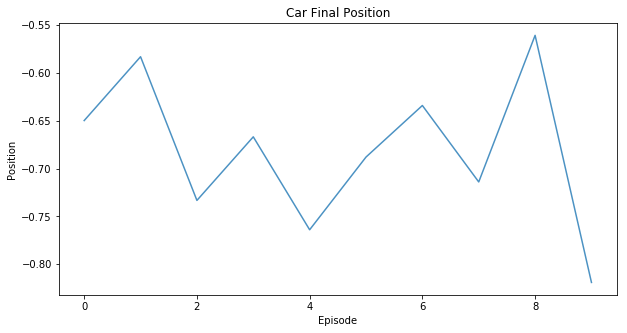

In [6]:
plt.figure(2, figsize=[10,5])
p = pd.Series(position)
ma = p.rolling(10).mean()
plt.plot(p, alpha=0.8)
plt.plot(ma)
plt.xlabel('Episode')
plt.ylabel('Position')
plt.title('Car Final Position')
plt.savefig('Final Position.png')
plt.show()

### Plot Policy

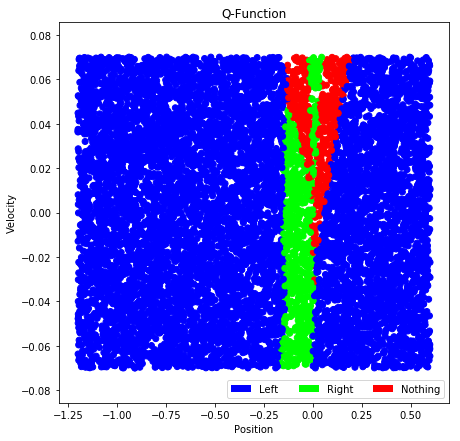

In [7]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

X = np.random.uniform(-1.2, 0.6, 10000)
Y = np.random.uniform(-0.07, 0.07, 10000)
Z = []
for i in range(len(X)):
    # Get the best action for the distribution of states
    #_, temp = torch.max(q_func(np.array([X[i],Y[i]])), dim =-1)
    temp = tf.math.argmax(q_func.forward(np.array([X[i],Y[i]])))
    
    z = temp.numpy()
    Z.append(z)
Z = pd.Series(Z)
colors = {0:'blue',1:'lime',2:'red'}
colors = Z.apply(lambda x:colors[x])
labels = ['Left','Right','Nothing']

fig = plt.figure(3, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
surf = ax.scatter(X,Y, c=Z)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Q-Function')
recs = []
for i in range(0,env.action_space.n):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
plt.legend(recs,labels,loc=4,ncol=env.action_space.n)
fig.savefig('Q_function.png')
plt.show()

### Try trained Model

In [9]:
state = env.reset()
done = False
step = 0
while not done:
    Q = q_func.forward(state)
    action = tf.math.argmax(Q)
    action = action.numpy()
    
    next_state, reward, done, info = env.step(action)
    state = next_state
    step += 1
    print("Step: {}".format(step))
    env.render()
    clear_output(wait=True)

Step: 200
